# Inception V4 - Tryout

Here are all thoughts and experiments I have done with Inception V4:
* First run with 1 epoch, batch size 16: 
  * 88/88 - 801s (13 mins) 9s/step - loss: 2.5718 - accuracy: 0.1967 - val_loss: 12.0336 - val_accuracy: 0.6695
  * 63/63 - 1147s - loss: 95176.3750 - accuracy: 0.6695 - 1147s/epoch - 18s/step
* Reduced Bach size to 16 to reduce memory usage.

Source material:
- https://medium.com/@AnasBrital98/inception-v4-cnn-architecture-explained-23a7fe12c727 (Inception v4 architecture)
- https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/InceptionV3 (Inception v3)

## Imports and inital setup

In [1]:
# Imports
from helperfunctions import modelhelper as mh
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
from tensorflow.keras.layers import concatenate
from keras.layers import Conv2D, MaxPool2D, Input, GlobalAveragePooling2D, AveragePooling2D, Dense, Dropout, Activation, BatchNormalization

import sys

sys.path.append("..")

SEED = 42
NUM_EPOCHS = 1

# File path variables
# please make sure to use the correct path to the meta data file

FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_PROCESSED = "./../data/processed/"
FILEPATH_OUTPUT = './../data/jpgs/'  # Replace with your folder path

TARGET_LABEL = "dx"
BALANCE_LABEL = "dx"
IMAGE_SIZE = (299, 299)
BATCH_SIZE = 16

### Loading (augmented) metadata as test, train, validation from files

In [2]:
# Read the metadata file
train_df = pd.read_csv(FILEPATH_PROCESSED+"train_from_Metadata_processed.csv")
validation_df = pd.read_csv(FILEPATH_PROCESSED+"validation_from_Metadata_processed.csv")
test_df = pd.read_csv(FILEPATH_PROCESSED+"test_from_Metadata_processed.csv")

train_df.sample(15)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,dx_binary,image_path
699,HAM_0000020,ISIC_0031922.jpg,akiec,histo,60.0,female,face,rosendahl,skin_cancer,./../data/jpgs/ISIC_0031922.jpg
1307,HAM_0000757,aug_CwPqPcISIC_0025314.jpg,df,consensus,35.0,female,lower extremity,vidir_molemax,not_skin_cancer,./../data/jpgs/aug_CwPqPcISIC_0025314.jpg
326,HAM_0004880,ISIC_0028583.jpg,bcc,histo,65.0,male,back,rosendahl,skin_cancer,./../data/jpgs/ISIC_0028583.jpg
180,HAM_0006608,ISIC_0027827.jpg,nv,histo,60.0,male,back,vienna_dias,not_skin_cancer,./../data/jpgs/ISIC_0027827.jpg
1074,HAM_0005022,ISIC_0027367.jpg,bkl,histo,70.0,female,lower extremity,rosendahl,not_skin_cancer,./../data/jpgs/ISIC_0027367.jpg
1342,HAM_0004371,aug_3dmcrLISIC_0027626.jpg,df,histo,45.0,female,upper extremity,rosendahl,not_skin_cancer,./../data/jpgs/aug_3dmcrLISIC_0027626.jpg
200,HAM_0005371,ISIC_0031154.jpg,bcc,histo,65.0,female,face,rosendahl,skin_cancer,./../data/jpgs/ISIC_0031154.jpg
766,HAM_0004568,ISIC_0024463.jpg,akiec,histo,50.0,male,upper extremity,rosendahl,skin_cancer,./../data/jpgs/ISIC_0024463.jpg
681,HAM_0001416,ISIC_0025427.jpg,akiec,histo,85.0,male,upper extremity,rosendahl,skin_cancer,./../data/jpgs/ISIC_0025427.jpg
752,HAM_0002745,ISIC_0024562.jpg,akiec,histo,75.0,male,chest,rosendahl,skin_cancer,./../data/jpgs/ISIC_0024562.jpg


## Setting up the image data generator for training and validation

In [3]:
# Setting up the Image Data Generator for the train data set - including augmentation

datagen_train = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Rescale pixel values to [0, 1], important for CNNs to perform better, deactivate to see images down below
)

datagen_validation = ImageDataGenerator(
    rescale=1.0 / 255.0 #see above
)

validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_df,
    directory=FILEPATH_JPGS,
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

train_data_generator = datagen_train.flow_from_dataframe(
        dataframe=train_df,
        directory=FILEPATH_JPGS,
        x_col="image_id",
        y_col=TARGET_LABEL,
        class_mode="categorical",
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE
)

Found 2003 validated image filenames belonging to 7 classes.
Found 1403 validated image filenames belonging to 7 classes.


# Testing Inception v4

In [4]:
def conv2d_with_Batch(prev_layer , nbr_kernels , filter_size , strides = (1,1) , padding = 'valid'):
    x = Conv2D(filters = nbr_kernels, kernel_size = filter_size, strides=strides , padding=padding) (prev_layer)
    x = BatchNormalization()(x)
    x = Activation(activation = 'relu') (x)
    return x

def stemBlock(prev_layer):
    x = conv2d_with_Batch(prev_layer, nbr_kernels = 32, filter_size = (3,3), strides = (2,2))
    x = conv2d_with_Batch(x, nbr_kernels = 32, filter_size = (3,3))
    x = conv2d_with_Batch(x, nbr_kernels = 64, filter_size = (3,3))
    
    x_1 = conv2d_with_Batch(x, nbr_kernels = 96, filter_size = (3,3), strides = (2,2) )
    x_2 = MaxPool2D(pool_size=(3,3) , strides=(2,2) ) (x)
    
    x = concatenate([x_1 , x_2], axis = 3)
    
    x_1 = conv2d_with_Batch(x, nbr_kernels = 64, filter_size = (1,1))
    x_1 = conv2d_with_Batch(x_1, nbr_kernels = 64, filter_size = (1,7) , padding ='same')
    x_1 = conv2d_with_Batch(x_1, nbr_kernels = 64, filter_size = (7,1), padding ='same')
    x_1 = conv2d_with_Batch(x_1, nbr_kernels = 96, filter_size = (3,3))
    
    x_2 = conv2d_with_Batch(x, nbr_kernels = 96, filter_size = (1,1))
    x_2 = conv2d_with_Batch(x_2, nbr_kernels = 96, filter_size = (3,3))
    
    x = concatenate([x_1 , x_2], axis = 3)
    
    x_1 = conv2d_with_Batch(x, nbr_kernels = 192, filter_size = (3,3) , strides=2)
    x_2 = MaxPool2D(pool_size=(3,3) , strides=(2,2) ) (x)
    
    x = concatenate([x_1 , x_2], axis = 3)
    
    return x

def reduction_A_Block(prev_layer) :
    x_1 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 192, filter_size = (1,1))
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 224, filter_size = (3,3) , padding='same')
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 256, filter_size = (3,3) , strides=(2,2)) 
    
    x_2 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 384, filter_size = (3,3) , strides=(2,2))
    
    x_3 = MaxPool2D(pool_size=(3,3) , strides=(2,2))(prev_layer)
    
    x = concatenate([x_1 , x_2 , x_3], axis = 3)
    
    return x

def reduction_B_Block(prev_layer):
    x_1 = MaxPool2D(pool_size=(3,3) , strides=(2,2))(prev_layer)
    
    x_2 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 192, filter_size = (1,1))
    x_2 = conv2d_with_Batch(prev_layer = x_2, nbr_kernels = 192, filter_size = (3,3) , strides=(2,2) )
    
    x_3 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 256, filter_size = (1,1) )
    x_3 = conv2d_with_Batch(prev_layer = x_3, nbr_kernels = 256, filter_size = (1,7) , padding='same')
    x_3 = conv2d_with_Batch(prev_layer = x_3, nbr_kernels = 320, filter_size = (7,1) , padding='same')
    x_3 = conv2d_with_Batch(prev_layer = x_3, nbr_kernels = 320, filter_size = (3,3) , strides=(2,2))
    
    x = concatenate([x_1 , x_2 , x_3], axis = 3)
    return x

def InceptionBlock_A(prev_layer): #I'm Here
    
    x_1 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 64, filter_size = (1,1))
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 96, filter_size = (3,3) , strides=(1,1), padding='same' )
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 96, filter_size = (3,3) , strides=(1,1) , padding='same')
    
    x_2 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 64, filter_size = (1,1))
    x_2 = conv2d_with_Batch(prev_layer = x_2, nbr_kernels = 96, filter_size = (3,3) , padding='same')
    
    x_3 = AveragePooling2D(pool_size=(3,3) , strides=1 , padding='same')(prev_layer)
    x_3 = conv2d_with_Batch(prev_layer = x_3, nbr_kernels = 96, filter_size = (1,1) , padding='same')
    
    x_4 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 96, filter_size = (1,1))
    
    output = concatenate([x_1 , x_2 , x_3 , x_4], axis = 3)

    return output
    
def InceptionBlock_B(prev_layer):
    
    x_1 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 192, filter_size = (1,1))
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 192, filter_size = (7,1) , padding='same')
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 224, filter_size = (1,7) , padding='same')
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 224, filter_size = (7,1) , padding='same')
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 256, filter_size = (1,7), padding='same')
    
    x_2 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 192, filter_size = (1,1))
    x_2 = conv2d_with_Batch(prev_layer = x_2, nbr_kernels = 224, filter_size = (1,7) , padding='same')
    x_2 = conv2d_with_Batch(prev_layer = x_2, nbr_kernels = 256, filter_size = (7,1), padding='same')
    
    x_3 = AveragePooling2D(pool_size=(3,3) , strides=1 , padding='same')(prev_layer)
    x_3 = conv2d_with_Batch(prev_layer = x_3, nbr_kernels = 128, filter_size = (1,1))
    
    x_4 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 384, filter_size = (1,1))

    output = concatenate([x_1 , x_2 ,x_3, x_4], axis = 3) 
    return output


def InceptionBlock_C(prev_layer):
    
    x_1 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 384, filter_size = (1,1))
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 448, filter_size = (3,1) , padding='same')
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 512, filter_size = (1,3) , padding='same')
    x_1_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 256, filter_size = (1,3), padding='same')
    x_1_2 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 256, filter_size = (3,1), padding='same')
    x_1 = concatenate([x_1_1 , x_1_2], axis = 3)
    
    x_2 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 384, filter_size = (1,1))
    x_2_1 = conv2d_with_Batch(prev_layer = x_2, nbr_kernels = 256, filter_size = (1,3), padding='same')
    x_2_2 = conv2d_with_Batch(prev_layer = x_2, nbr_kernels = 256, filter_size = (3,1), padding='same')
    x_2 = concatenate([x_2_1 , x_2_2], axis = 3)
    
    x_3 = MaxPool2D(pool_size=(3,3),strides = 1 , padding='same')(prev_layer)
    x_3 = conv2d_with_Batch(prev_layer = x_3, nbr_kernels = 256, filter_size = 3  , padding='same')
    
    x_4 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 256, filter_size = (1,1))
    
    output = concatenate([x_1 , x_2 , x_3 , x_4], axis = 3)
    
    return output

def InceptionV4():
    
    input_layer = Input(shape=(299 , 299 , 3))
    
    x = stemBlock(prev_layer=input_layer)
    
    x = InceptionBlock_A(prev_layer=x)
    x = InceptionBlock_A(prev_layer=x)
    x = InceptionBlock_A(prev_layer=x)
    x = InceptionBlock_A(prev_layer=x)
    
    x = reduction_A_Block(prev_layer=x)
    
    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)
    
    x = reduction_B_Block(prev_layer= x)
    
    x = InceptionBlock_C(prev_layer=x)
    x = InceptionBlock_C(prev_layer=x)
    x = InceptionBlock_C(prev_layer=x)
    
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(units = 1536, activation='relu') (x)
    x = Dropout(rate = 0.8) (x)
    x = Dense(units = 7, activation='softmax')(x) # changed from 1000 to 7 for the 7 classes
    
    model = Model(inputs = input_layer , outputs = x , name ='Inception-V4')
    
    return model

In [5]:
model = InceptionV4()

In [6]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy' , metrics=['accuracy'])

model.summary()

Model: "Inception-V4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalizati

                                                                                                  
 batch_normalization_4 (Bat  (None, 72, 72, 64)           256       ['conv2d_4[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_4 (Activation)   (None, 72, 72, 64)           0         ['batch_normalization_4[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_5 (Conv2D)           (None, 72, 72, 64)           28736     ['activation_4[0][0]']        
                                                                                                  
 batch_normalization_5 (Bat  (None, 72, 72, 64)           256       ['conv2d_5[0][0]']            
 chNormali

## Model Training

In [7]:
# Train the model

history = model.fit(
    train_data_generator,
    epochs=NUM_EPOCHS,              
    verbose=1,                      # Adjust verbosity level
    batch_size=BATCH_SIZE,                # Set the batch size, default is 32, can be increased to speed up training, but memory consumption increases
    callbacks=None,                 # List of callbacks to apply during training 
    validation_split=0.0,           # not needed as we use a validation data generator
    validation_data=validation_generator,
    shuffle=True,                   # Shuffle the training data before each epoch
    sample_weight=None,             # Set the weights for the train data set !
    class_weight=None,              # Set the weights for the classes, not needed if we use sample weights
    initial_epoch=0,                # Use this to continue training from a specific epoch
    steps_per_epoch=None,           # Set the number of steps per epoch, default is len(x_train) // batch_size
    validation_steps=None,          # Set the number of steps for validation, default is len(x_val) // batch_size
    validation_batch_size=None,     # Set the batch size for validation, default is batch_size
    validation_freq=1,              # Only relevant if validation data is a generator. Set the frequency to validate the model on the validation set
    max_queue_size=10,              # Set the max size for the generator queue
    workers=-1,                     # Set the max number of processes to generate the data in parallel, -1 means all CPUs
    use_multiprocessing=False       # Set to True if you use a generator in parallel, e.g. model.predict_generator()
)

88/88 [==============================] - 801s 9s/step - loss: 2.5718 - accuracy: 0.1967 - val_loss: 12.0336 - val_accuracy: 0.6695


## Plotting accuracy and loss of train and validation set

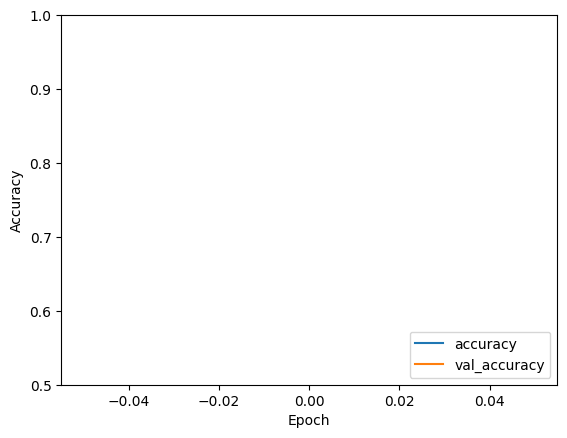

In [8]:
mh.model_plot_accuracy(history)

## Evaluating the model on the test set

In [9]:
mh.model_accuracy_on_test(model, test_df, TARGET_LABEL, IMAGE_SIZE)

63/63 - 1147s - loss: 95176.3750 - accuracy: 0.6695 - 1147s/epoch - 18s/step


## Saving the model

In [10]:
from datetime import datetime
timestamp = datetime.now()
model_path = f"../models/model_{timestamp}.h5"
model.save(model_path)

/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
